In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Activation, MaxPooling2D
from keras.preprocessing.image import  array_to_img, img_to_array, load_img
from keras.preprocessing.image import ImageDataGenerator
import os
import gdown
from zipfile import ZipFile
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

from matplotlib import pyplot as plt

from tqdm import tqdm
from PIL import Image


In [3]:
os.makedirs("celeba_gan")

url = "https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684"
output = "celeba_gan/data.zip"
gdown.download(url, output, quiet=True)

with ZipFile("celeba_gan/data.zip", "r") as zipobj:
    zipobj.extractall("celeba_gan")


In [6]:
dataset = keras.preprocessing.image_dataset_from_directory("celeba_gan", label_mode=None, image_size=(64, 64), batch_size=32)
dataset = dataset.map(lambda x: x / 255.0)



Found 202599 files belonging to 1 classes.


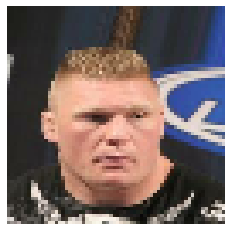

In [7]:
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break


In [8]:
discriminator = Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(64,activation='relu'),
        layers.Dense(64,activation='relu'),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()


Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         262272    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 128)       

In [9]:
latent_dim = 64

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 64),
        layers.Reshape((8, 8, 64)),
        layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()



Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 4096)              266240    
                                                                 
 reshape (Reshape)           (None, 8, 8, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 64)       65600     
 nspose)                                                         
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 128)      131200    
 ranspose)                                                       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 32, 32, 128)       0 

In [10]:


class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):

        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))


        generated_images = self.generator(random_latent_vectors)


        combined_images = tf.concat([generated_images, real_images], axis=0)


        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )

        labels += 0.05 * tf.random.uniform(tf.shape(labels))


        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )


        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

 
        misleading_labels = tf.zeros((batch_size, 1))

     
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

    
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
    
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }


In [11]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save("/content/drive/MyDrive/GAN/train-2/generated_img_%03d_%d.png" % (epoch, i))


In [12]:
gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)

In [18]:
epochs = 30

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)



SyntaxError: ignored

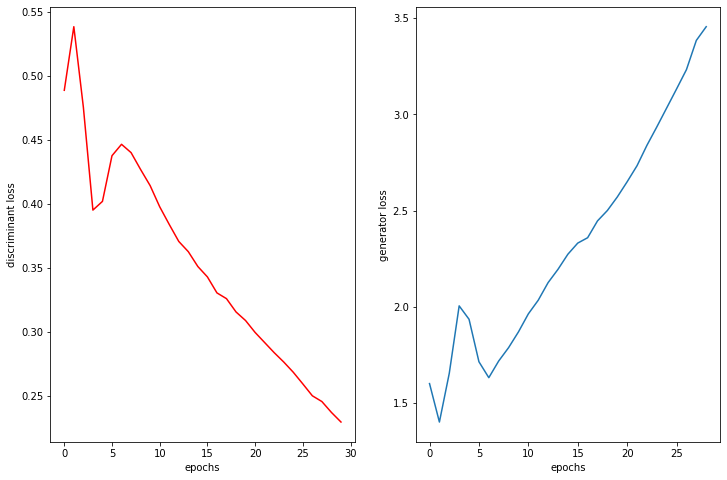

In [ ]:
d_loss = [0.4885, 0.5382, 0.4753, 0.3949, 0.4017, 0.4374, 0.4463, 0.4398, 0.4266, 0.4140, 0.3975, 0.3837, 0.3704, 0.3624, 0.3508,0.3427, 0.3302, 0.3257, 0.3153, 0.3086, 0.2993, 0.2914, 0.2835, 0.2762, 0.2682, 0.2591, 0.2498, 0.2453, 0.2368,0.2293 ]
g_loss = [1.6018, 1.4021, 1.6555, 2.0054, 1.9358, 1.7153, 1.6325, 1.7191, 1.7884, 1.8703, 1.9639, 2.0347, 2.1262, 2.1952, 2.2736, 2.3315, 2.3594, 2.4468, 2.5009, 2.5709, 2.6501, 2.7335, 2.8392, 2.9348, 3.0334, 3.1321, 3.2325, 3.3842, 3.4555 ]

plt.figure(1, figsize=(12, 8))
plt.subplot(121)
plt.plot(d_loss, color='red')
plt.xlabel('epochs')
plt.ylabel('discriminant loss')
plt.subplot(122)
plt.plot(g_loss)
plt.xlabel('epochs')
plt.ylabel('generator loss')
plt.show()

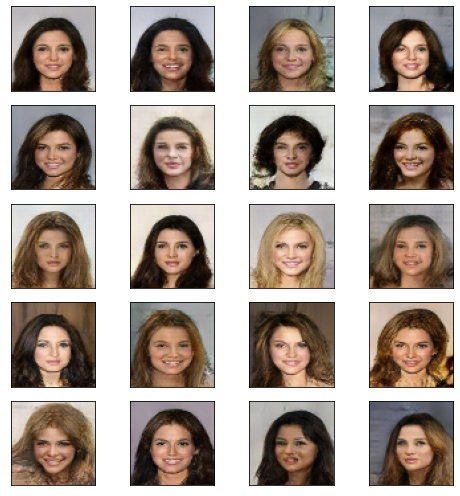

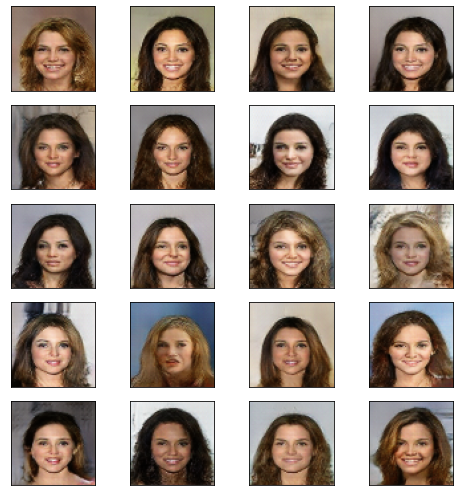

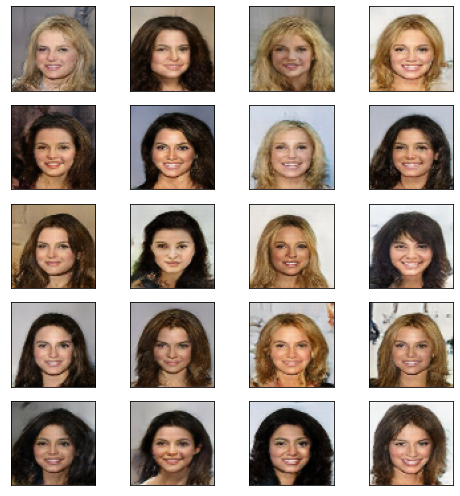

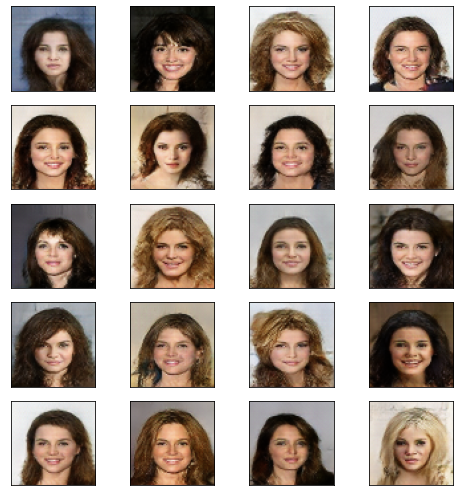

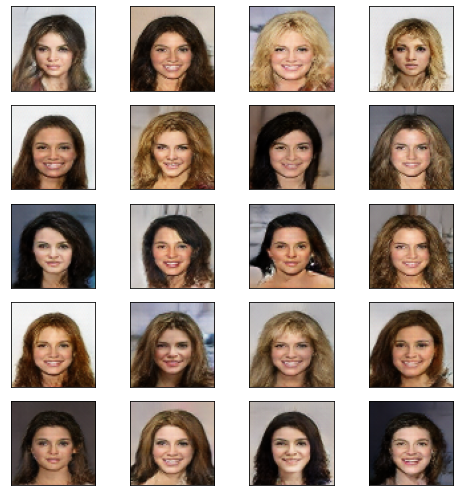

In [17]:
for i in range(5):
 plt.figure(figsize=(7,7))   
 for k in range(20):
            noise=np.random.uniform(-1,1,size=[100,latent_dim])
            im=generator.predict(noise) 
            plt.subplot(5, 4, k+1)
            plt.imshow(im[k].reshape(64,64,3))
            plt.xticks([])
            plt.yticks([])
 
 plt.tight_layout()
 plt.show()

In [ ]:
|                   1  